# AutoDRIVE-RoboRacer Sim Racing League
## Participant Analysis

Import libraries

In [1]:
import pandas as pd
import os
import plotly.express as px
import random
from PIL import Image
from IPython.display import display

Load registration data

In [2]:
# Load the data from Excel sheet
df = pd.read_excel("Registration.xlsx", sheet_name="CDC-TF 2025", header=None)

# Fill merged cell information
df.columns = ['SR NO', 'TEAM NAME', 'TEAM MEMBER', 'ORGANIZATION', 'COUNTRY']
df[['SR NO', 'TEAM NAME', 'ORGANIZATION', 'COUNTRY']] = df[['SR NO', 'TEAM NAME', 'ORGANIZATION', 'COUNTRY']].fillna(method='ffill')

# Drop empty rows (if any)
df = df.dropna(subset=['TEAM MEMBER'])

# See the data (sanity check)
df.head()

,SR NO,TEAM NAME,TEAM MEMBER,ORGANIZATION,COUNTRY
0,1.0,魔法师大大,Chen Zexiang,Personal,China
1,2.0,Mamba,Hariharan Ravichandran,Personal,United States of America (USA)
2,3.0,Finding Theta,Michael Kudlaty,Personal,United States of America (USA)
3,4.0,Devrim,Melih Akay,Middle East Technical University,Türkiye
4,5.0,Khepa_BobCats,MdSakifUddin Khan,Personal,United States of America (USA)


Create a collage of organization logos

⚠️ Canvas size deviates from 1920x1080 (ratio = 1.78) to 1920x1464 (ratio = 1.31)
✅ Collage saved successfully!


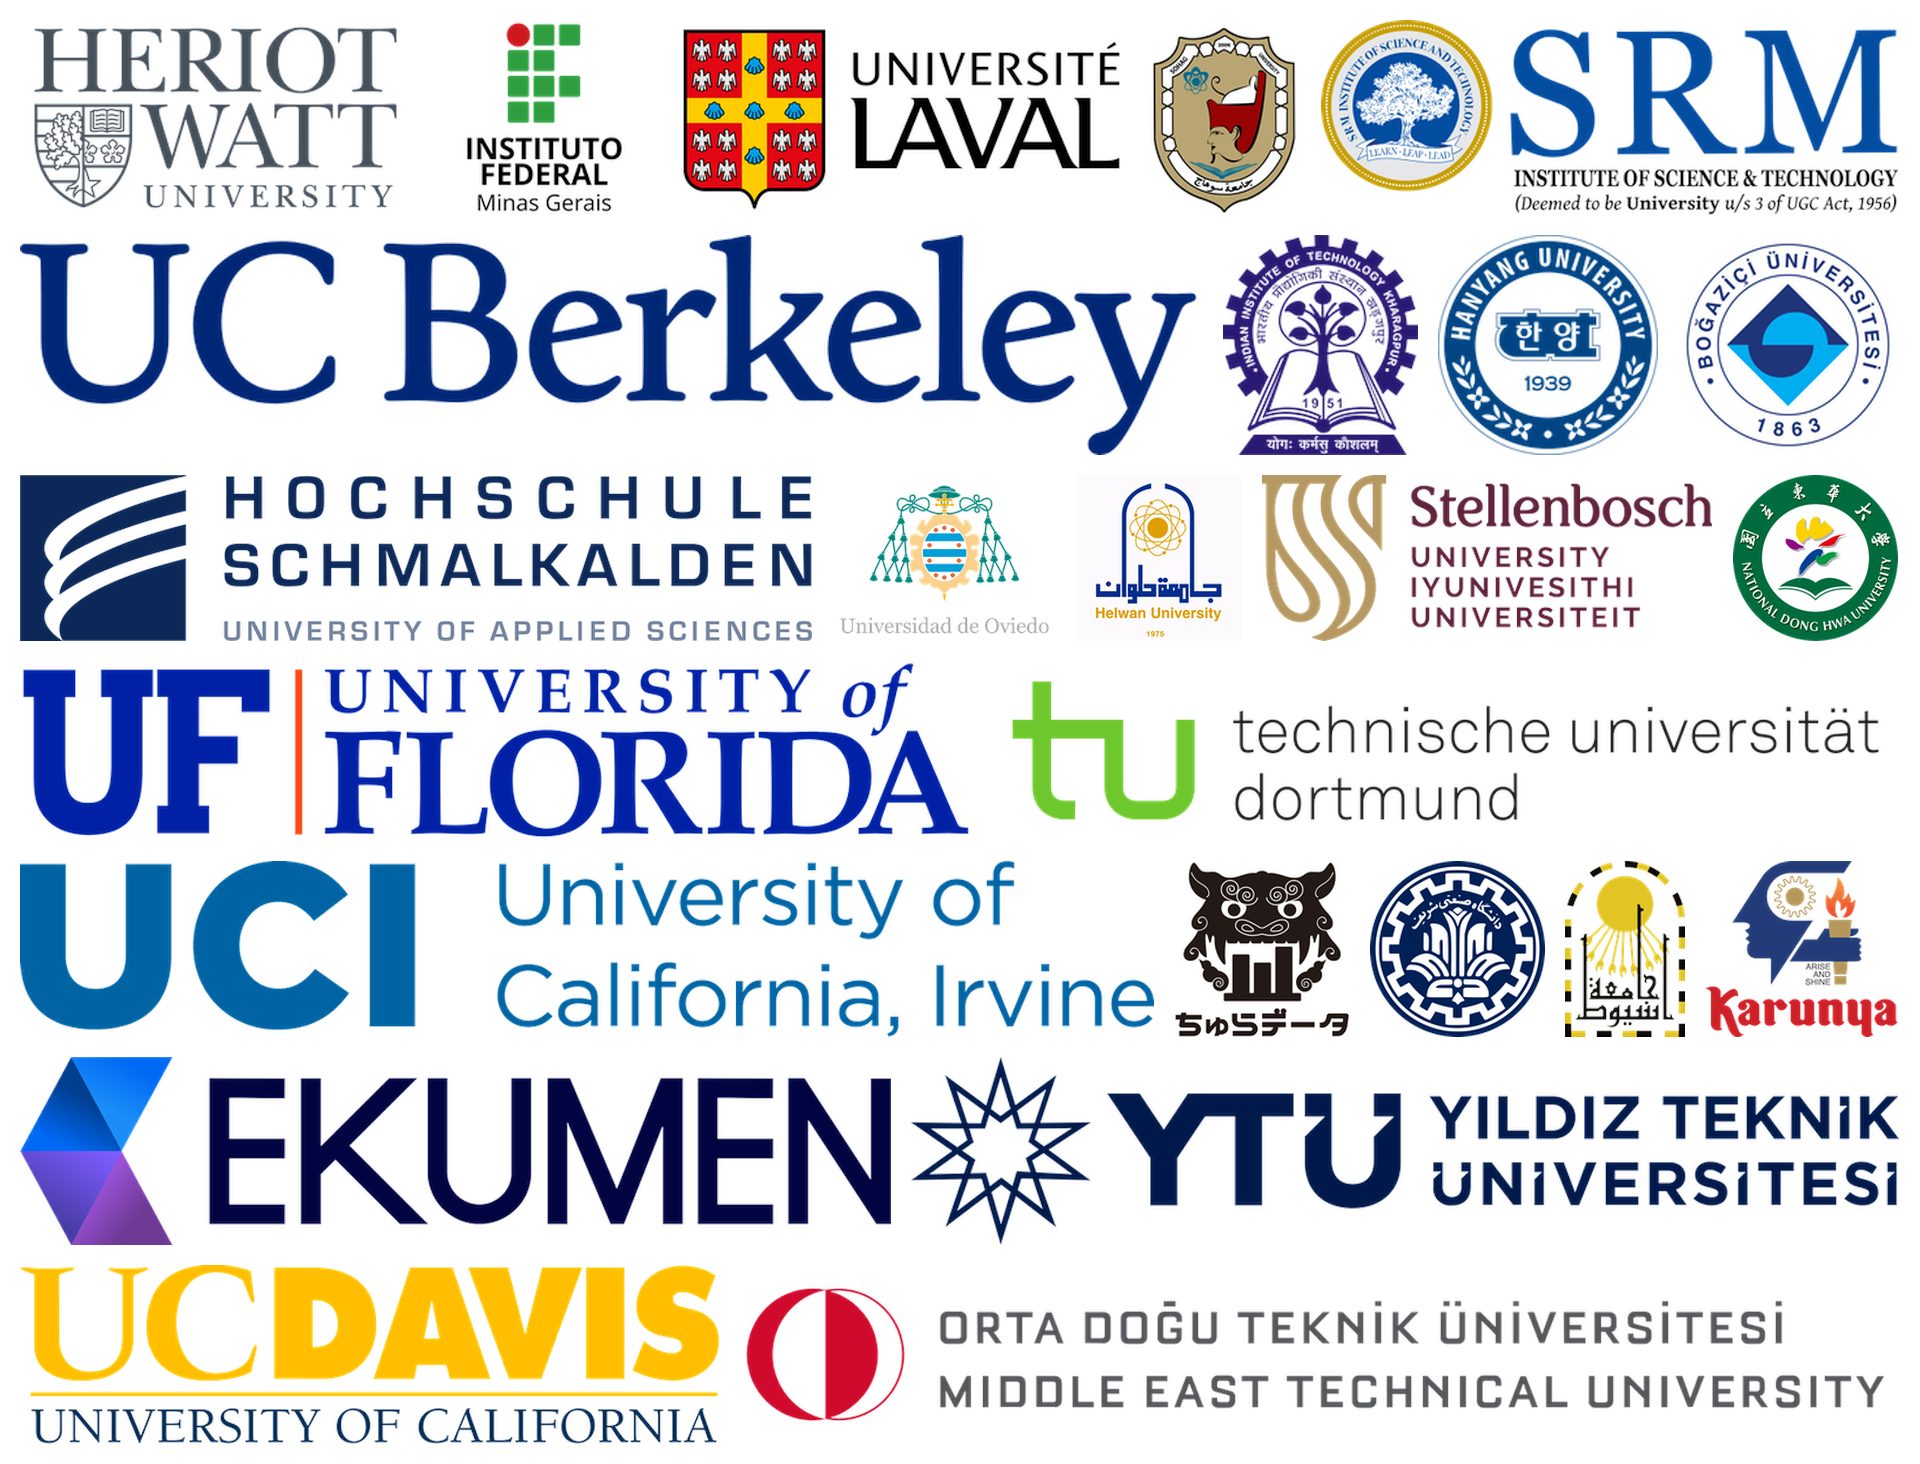

In [8]:
def adaptive_masonry_style_collage(
    folder_path,
    output_path='Collage.png',
    canvas_size=(1920, 1080),
    target_row_height=160,
    padding=10,
    bg_color=(255, 255, 255),
    sort='area',
    mix=True,
    allow_dynamic_height=True
):
    canvas_w, _ = canvas_size

    # Load and preprocess logos
    logo_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    logos = []
    for fname in logo_files:
        img = Image.open(os.path.join(folder_path, fname)).convert("RGBA")
        w, h = img.size
        scale = target_row_height / h
        new_w = int(w * scale)
        resized = img.resize((new_w, target_row_height), Image.Resampling.LANCZOS)
        logos.append((resized, new_w, target_row_height))

    # Sort logos to improve packing
    if sort=='width':
        logos.sort(key=lambda x: x[1], reverse=True) # Sort by width
    elif sort=='area':
        logos.sort(key=lambda x: x[1] * x[2], reverse=True) # Sort by area
    else:
        raise Exception("Invalid method of sorting to improve packing: choose `width` or `area`")
    
    # Mix logos to avoid clustering by size/aspect ratio
    if mix:
        random.shuffle(logos)

    # Group logos into rows
    rows = []
    current_row = []
    current_width = 0

    for logo, lw, lh in logos:
        if current_width + lw + padding * (len(current_row) + 1) > canvas_w:
            rows.append(current_row)
            current_row = []
            current_width = 0
        current_row.append((logo, lw, lh))
        current_width += lw
    if current_row:
        rows.append(current_row)

    # Calculate required canvas height dynamically
    total_height = 0
    row_heights = []
    for row in rows:
        total_row_width = sum(lw for _, lw, _ in row)
        scaling_factor = (canvas_w - (len(row) + 1) * padding) / total_row_width
        row_height = int(target_row_height * scaling_factor)
        row_heights.append(row_height)
        total_height += row_height + padding

    # Top and bottom padding
    total_height += padding 

    # Use new height if dynamic height is allowed and needed
    if allow_dynamic_height and total_height > canvas_size[1]:
        canvas_h = total_height
        ratio = canvas_w / canvas_h
        ideal_ratio = canvas_size[0]/canvas_size[1]
        if abs(ratio - ideal_ratio) > 0.1:
            print(f"⚠️ Canvas size deviates from {canvas_size[0]}x{canvas_size[1]} (ratio = {ideal_ratio:.2f}) to {canvas_w}x{canvas_h} (ratio = {ratio:.2f})")
    else:
        canvas_h = canvas_size[1]

    # Create canvas
    collage = Image.new("RGBA", (canvas_w, canvas_h), bg_color)

    # Paste rows
    y = padding
    for i, row in enumerate(rows):
        total_row_width = sum(lw for _, lw, _ in row)
        scaling_factor = (canvas_w - (len(row) + 1) * padding) / total_row_width
        row_height = int(target_row_height * scaling_factor)

        x = padding
        for logo, lw, lh in row:
            new_w = int(lw * scaling_factor)
            resized_logo = logo.resize((new_w, row_height), Image.Resampling.LANCZOS)
            collage.paste(resized_logo, (x, y), resized_logo)
            x += new_w + padding

        y += row_height + padding

    # Save the collage
    collage.save(output_path)
    print(f"✅ Collage saved successfully!")
    display(collage)

adaptive_masonry_style_collage(
    folder_path="Organization Logos/CDC-TF 2025",
    output_path="Collage.png",
    canvas_size=(1920, 1080),
    target_row_height=150,
    padding=20,
    sort='area',
    mix=True,
    allow_dynamic_height=True
)

Plot world map with strength by registration

In [ ]:
# Clean country names if needed (create an alias map)
country_alias_map = {
    "USA": "United States",
    "U.S.": "United States",
    "United States of America (USA)": "United States",
    "United States (US)": "United States",
    "UAE": "United Arab Emirates",
    "United Arab Emirates (UAE)": "United Arab Emirates",
    "Côte d'Ivoire": "Ivory Coast",
    "South Korea": "South Korea",
    "Republic of Korea": "South Korea",
    "Republic of Türkiye": "Turkey",
    "Turkiye": "Turkey",
    "Türkiye": "Turkey",
    "UK": "United Kingdom",
    "U.K.": "United Kingdom",
    # Add others if needed
}

df_split = df.copy() # Make a copy of the original dataframe

# Split multiple countries into separate rows
df_split['COUNTRY'] = df_split['COUNTRY'].str.replace(r'\s*&\s*|\s*/\s*|\s+and\s+', ',', regex=True) # Replace common multi-country separators with comma
df_split['COUNTRY'] = df_split['COUNTRY'].str.split(',') # Split into lists
df_split = df_split.explode('COUNTRY') # Explode so each country gets its own row
df_split['COUNTRY'] = df_split['COUNTRY'].str.strip() # Strip whitespace
df_split['COUNTRY'] = df_split['COUNTRY'].replace(country_alias_map) # Apply country mapping to clean up aliases

# Compute stats
total_participants = df.shape[0] # Total number of participants
total_teams = df['TEAM NAME'].nunique() # Total number of teams
total_organizations = df['ORGANIZATION'].nunique() # Total number of organizations
total_countries = df_split['COUNTRY'].nunique() # Total number of countries

teams_per_country = df_split.groupby('COUNTRY')['TEAM NAME'].nunique() # Count number of teams per country
participants_per_country = df_split['COUNTRY'].value_counts() # Count number of participants per country
orgs_per_country = df_split.groupby('COUNTRY')['ORGANIZATION'].nunique() # Count number of organizations per country
# Aggregate stats into a DataFrame
country_stats = pd.DataFrame({
    'Teams': teams_per_country,
    'Participants': participants_per_country,
    'Organizations': orgs_per_country
}).reset_index().rename(columns={'index': 'Country'})

# Create choropleth map
fig = px.choropleth(
    country_stats,
    locations="Country",
    locationmode="country names",
    color="Teams",
    hover_name="Country",
    hover_data={
        "Country": False,
        "Teams": True,
        "Participants": True,
        "Organizations": True,
    },
    color_continuous_scale="rainbow",
)
fig.update_layout(
    title={
        'text': "🌍 Global Participation Map<br>"
                "<span style='font-size:10px; color:gray;'>" +
                str(total_participants) + " Participants | " +
                str(total_teams) + " Teams | " +
                str(total_organizations) + " Organizations | " +
                str(total_countries) + " Countries" +
                "</span>",
        'x': 0.5,
        'xanchor': 'center'
    },
    
    margin=dict(l=10, r=10, t=70, b=10),
    geo=dict(showland=True, landcolor="lightgray", resolution=50),
    # width=960, # Uncomment to save static PNG, comment out to save adaptive HTML
    # height=595 # Uncomment to save static PNG, comment out to save adaptive HTML
)
fig.write_html("Map.html") # Save the map as an interactive HTML
print(f"✅ Map saved successfully!")
fig.show() # Show the map as interactive plot